In [34]:
# ==============================================
# ✅ SRDFN (Super-Resolution Dense Feature Network)
# For Histopathology Image Super-Resolution
# ==============================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.nn.functional as F
import cv2

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [21]:

# -----------------------------
# 🔹 SRDFN Model
# -----------------------------
class SRDFN(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_features=64):
        super(SRDFN, self).__init__()

        self.initial = nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1)

        self.dense_block = nn.Sequential(
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.reconstruction = nn.Sequential(
            nn.Conv2d(num_features, num_features * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.dense_block(x)
        x = self.reconstruction(x)
        return x

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Model dosya yolları
model_paths = {
    "srdfn": "models/srdfn_model.pth",
    "srcnn": "models/srcnn_model.pth",
    "espcn": "models/espcn_x2_256to512.pth",
    "edsr": "models/edsr_x2_256to512.pth",
}

def apply_super_resolution(model_name, image_path):
    # 🔹 Modeli yükle
    model = torch.load(model_paths[model_name], map_location="cpu")
    model.eval()

    # 🔹 Görüntüyü yükle ve tensöre çevir
    image = Image.open(image_path).convert("RGB")
    input_tensor = transforms.ToTensor()(image).unsqueeze(0)  # [1, 3, H, W]

    # 🔹 Modeli uygula
    with torch.no_grad():
        sr = model(input_tensor)

    # 🔹 Çıktıyı görüntüye dönüştür
    sr_image = sr.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.imshow(sr_result)
    plt.axis("off")
    plt.title("SR Output")
    plt.show()
    return sr_image


sr_result = apply_super_resolution("srdfn", "downsampled_images/human_bladder_01.png")


In [22]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2)
        )

    def forward(self, x):
        return self.model(x)


In [23]:
# Residual Block tanımı (BatchNorm yok)
class ResidualBlock(nn.Module):
    def __init__(self, num_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return out + residual  # Skip connection

# EDSR ana modeli
class EDSR(nn.Module):
    def __init__(self, scale_factor=2, num_channels=64, num_blocks=8):
        super(EDSR, self).__init__()
        self.entry = nn.Conv2d(3, num_channels, kernel_size=3, padding=1)

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_channels) for _ in range(num_blocks)]
        )

        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        self.upsample = nn.Sequential(
            nn.Conv2d(num_channels, 3 * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )

    def forward(self, x):
        x = self.entry(x)
        res = self.res_blocks(x)
        x = self.conv(res) + x  # Global skip connection
        x = self.upsample(x)
        return x


In [24]:
class ESPCN(nn.Module):
    def __init__(self, scale_factor=3):
        super(ESPCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3 * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.pixel_shuffle(x)
        return x


In [28]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Model dosya yolları
model_paths = {
    "srdfn": "models/srdfn_model.pth",
    "srcnn": "models/srcnn_model.pth",
    "espcn": "models/espcn_x2_256to512.pth",
    "edsr_me": "models/edsr_x2_256to512.pth",
    "lapsrn":"models/LapSRN_x2.pb",
    "edsr":"models/EDSR_x2.pb"
}

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def apply_super_resolution(model_name, image_path):
    model = torch.load(model_paths[model_name], map_location="cpu")
    model.eval()

    image = Image.open(image_path).convert("RGB")
    input_tensor = transforms.ToTensor()(image).unsqueeze(0)

    with torch.no_grad():
        sr = model(input_tensor)

    sr_image = sr.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # HR image ile aynı boyutta olduğundan emin ol
    hr_image = Image.open(image_path).convert("RGB").resize(sr_image.shape[:2][::-1])
    hr_tensor = transforms.ToTensor()(hr_image).permute(1, 2, 0).numpy()


    ssim_val = structural_similarity(sr_image, hr_tensor, channel_axis=-1, data_range=1.0)
    psnr_val = peak_signal_noise_ratio(hr_tensor, sr_image, data_range=1.0)

    print(f"PSNR: {psnr_val:.2f} dB")
    print(f"SSIM: {ssim_val:.4f}")

    plt.imshow(sr_image)
    plt.axis("off")
    plt.title(f"{model_name.upper()} Output")
    plt.show()

    return sr_image



C:\Users\Zeynep\AppData\Local\Temp\ipykernel_20356\2445948236.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_paths[model_name], map_location="

PSNR: 37.46 dB
SSIM: 0.9134


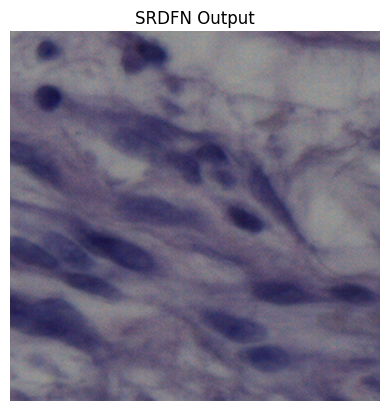

PSNR: 35.76 dB
SSIM: 0.9093


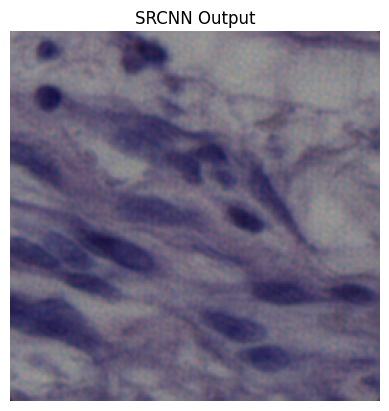

PSNR: 44.49 dB
SSIM: 0.9774


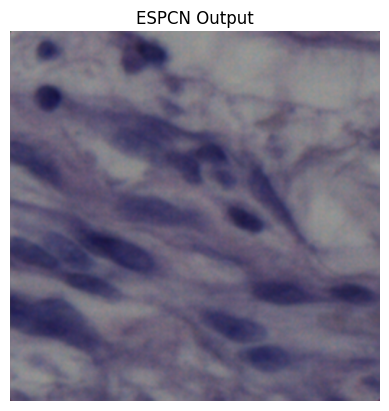

PSNR: 48.66 dB
SSIM: 0.9921


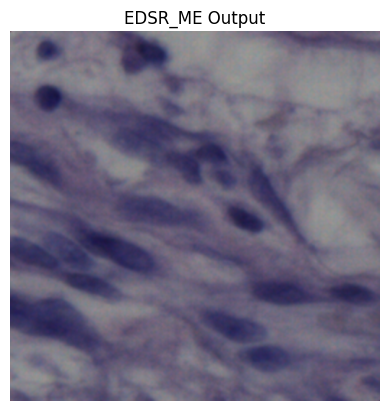

In [29]:
sr_img = apply_super_resolution("srdfn", "downsampled_images/human_bladder_01.png")
srcnn = apply_super_resolution("srcnn", "downsampled_images/human_bladder_01.png")
espcn = apply_super_resolution("espcn", "downsampled_images/human_bladder_01.png")
edsr = apply_super_resolution("edsr_me", "downsampled_images/human_bladder_01.png")


In [35]:
def apply_sr_opencv_models(model_name, image_path):
    
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_paths[model_name])
    sr.setModel(model_name, 2)

    image = cv2.imread(image_path)

    # 3. Super-Resolution uygula
    result = sr.upsample(image)

    # 4. BGR'den RGB'ye çevir (cv2 → plt için)
    sr_image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    hr = cv2.imread("downsampled_images/human_bladder_01.png")
    hr_rgb = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

    sr_norm = sr_image.astype(np.float32) / 255.0

    hr = cv2.imread(image_path)
    hr_rgb = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)

    # 2. HR görüntüyü SR boyutuna resize et
    h, w, _ = sr_image.shape  # SR boyutları
    hr_resized = cv2.resize(hr_rgb, (w, h), interpolation=cv2.INTER_CUBIC)

    hr_norm = hr_resized.astype(np.float32) / 255.0

    # 3. PSNR & SSIM hesapla
    psnr = peak_signal_noise_ratio(hr_norm, sr_norm, data_range=1.0)
    ssim = structural_similarity(hr_norm, sr_norm, channel_axis=2, data_range=1.0)

    print(f"🔍 PSNR: {psnr:.2f} dB")
    print(f"🔍 SSIM: {ssim:.4f}")
    
    plt.imshow(sr_image)
    plt.axis("off")
    plt.title(f"{model_name.upper()} Output")
    plt.show()

    return sr_image



🔍 PSNR: 46.74 dB
🔍 SSIM: 0.9868


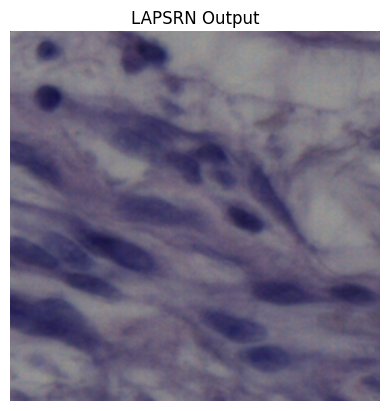

In [36]:
lapsrn = apply_sr_opencv_models("lapsrn", "downsampled_images/human_bladder_01.png")


🔍 PSNR: 52.95 dB
🔍 SSIM: 0.9970


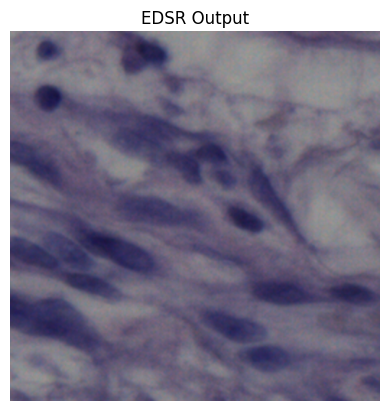

In [38]:
edsr_opencv= apply_sr_opencv_models("edsr", "downsampled_images/human_bladder_01.png")